In [1]:
# Install required packages
# !pip install numpy pandas matplotlib seaborn tensorflow Pillow scikit-learn


In [2]:
GLOBAL_RANDOM_SEED = 18

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import config
from PIL import Image
import os
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models, metrics, Input
#Use Python 3.10 since tensorflow does not support Python newer than that

np.random.seed(GLOBAL_RANDOM_SEED)
tf.random.set_seed(GLOBAL_RANDOM_SEED)
random.seed(GLOBAL_RANDOM_SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# 1. Read Data


In [3]:
#Create an config.py file to store your label_path and image_folder_path. So that we do not have to upload the dataset up to github, keep the dataset to our local
label_path = config.LABEL_PATH
image_folder_path = config.IMAGE_FOLDER_PATH


In [4]:
label_df = pd.read_csv(label_path)
label_df.shape

(9896, 6)

In [5]:
label_df

,InstanceID,patientID,ImageName,cellTypeName,cellType,isCancerous
0,22405,1,22405.png,fibroblast,0,0
1,22406,1,22406.png,fibroblast,0,0
2,22407,1,22407.png,fibroblast,0,0
3,22408,1,22408.png,fibroblast,0,0
4,22409,1,22409.png,fibroblast,0,0
...,...,...,...,...,...,...
9891,1625,60,1625.png,epithelial,2,1
9892,1626,60,1626.png,epithelial,2,1
9893,1627,60,1627.png,epithelial,2,1
9894,1628,60,1628.png,epithelial,2,1


## 2. EDA


### 2.1 Image Format check

In [6]:
# Define common image extensions
image_extensions ='.png'

all_files = [f for f in os.listdir(image_folder_path) if os.path.isfile(os.path.join(image_folder_path, f))]
total_files = len(all_files)

# Identify non-image files
non_image_files = [f for f in all_files if not f.lower().endswith(image_extensions)]

# Output results
print(f"Total files in folder: {total_files}")
print(f"Non-image files: {len(non_image_files)}")

if non_image_files:
    print("Files that are not images:")
    for file in non_image_files:
        print(f" - {file}")
else:
    print("All files are images ending with .png.")

Total files in folder: 20281
Non-image files: 1
Files that are not images:
 - patch-images.zip


In [7]:
def find_wrong_format_images(label_df, image_folder):
    """
    Identifies and returns a list of image names from a DataFrame that are
    not 27x27 pixels or are not in RGB color space according to the Assignment Detail.
    """
    wrong_format_images = []

    for index, row in label_df.iterrows():
        image_name = row['ImageName']
        image_path = os.path.join(image_folder, image_name)
        is_27x27 = False
        is_rgb = False

        try:
            img = Image.open(image_path)
            width, height = img.size
            if width == 27 and height == 27:
                is_27x27 = True

            if img.mode == 'RGB':
                is_rgb = True

            img.close()

            if not is_27x27 or not is_rgb:
                wrong_format_images.append(image_name)

        except FileNotFoundError:
            print(f"Warning: Image not found at {image_path}")
            wrong_format_images.append(image_name) # Consider it wrong_format if not found
        except Exception as e:
            print(f"Warning: Error processing {image_path}: {e}")
            wrong_format_images.append(image_name) # Consider it wrong_format if processing fails

    return wrong_format_images


wrong_format_image_list = find_wrong_format_images(label_df.copy(), image_folder_path)

if wrong_format_image_list:
    print("List of image names that are NOT 27x27 or NOT RGB:")
    for img_name in wrong_format_image_list:
        print(f"- {img_name}")
    print(f"\nTotal number of wrong format images found: {len(wrong_format_image_list)}")
else:
    print("All images in the list are 27x27 and RGB.")

All images in the list are 27x27 and RGB.


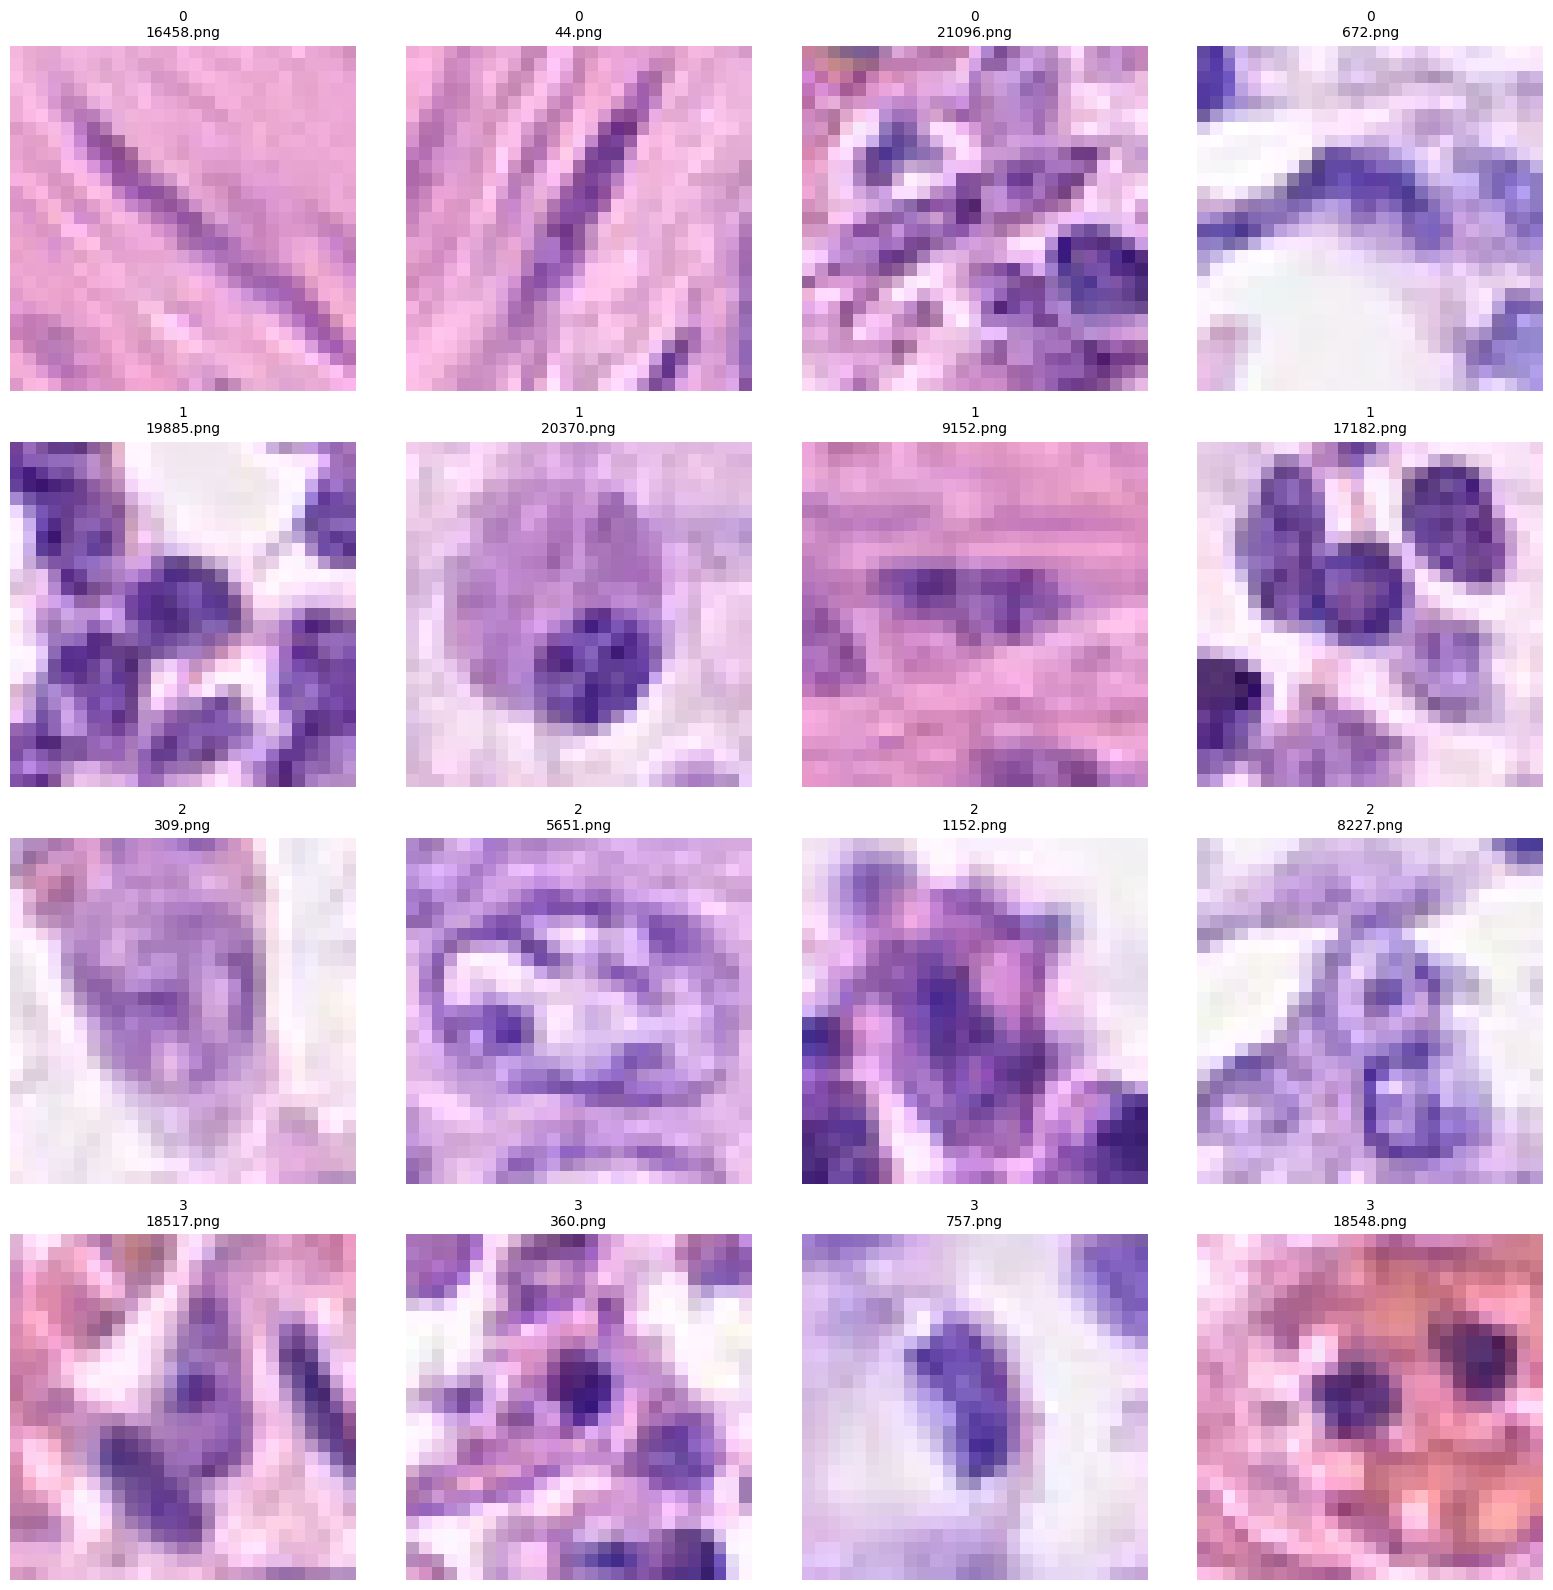

In [8]:
plt.figure(figsize=(16, 16))

img_index = 1

for i in range(0,4):
    # Randomly select 4 images for each cell type
    sample_rows = label_df[label_df["cellType"] == i].sample(n=4, random_state=42)

    for _, row in sample_rows.iterrows():
        img_path = os.path.join(image_folder_path, row["ImageName"])
        img = Image.open(img_path)

        plt.subplot(4, 4, img_index)
        plt.imshow(img, interpolation='nearest')
        plt.title(f'{i}\n{row["ImageName"]}', fontsize=10)
        plt.axis('off')

        img_index += 1

plt.tight_layout()
plt.show()

### 2.2 Distribution check and class imbalance

In [9]:
print(label_df.isna().sum())

InstanceID      0
patientID       0
ImageName       0
cellTypeName    0
cellType        0
isCancerous     0
dtype: int64


In [10]:
for col in ["cellType", "isCancerous"]:
    print(label_df[col].value_counts())

cellType
2    4079
1    2543
0    1888
3    1386
Name: count, dtype: int64
isCancerous
0    5817
1    4079
Name: count, dtype: int64


In [11]:
contingency_table = pd.crosstab(label_df['cellType'], label_df['isCancerous'], 
                                rownames=['Cell Type'], colnames=['Is Cancerous'])

print("\nContingency Table (cellType vs isCancerous):")
print(contingency_table)


Contingency Table (cellType vs isCancerous):
Is Cancerous     0     1
Cell Type               
0             1888     0
1             2543     0
2                0  4079
3             1386     0


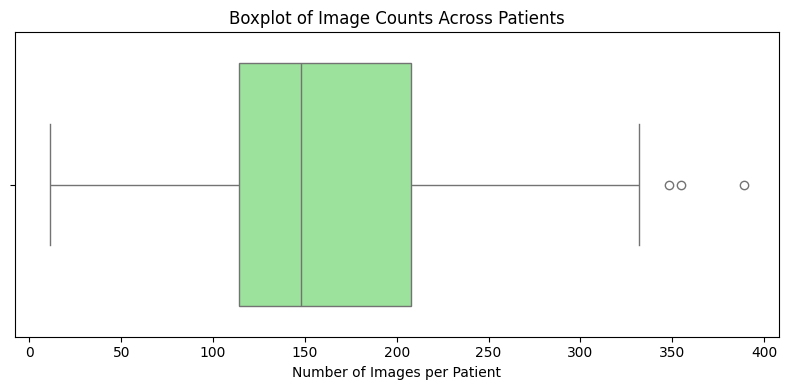

In [12]:
image_dis = label_df['patientID'].value_counts().sort_index()

#Plot to see the distribution and variance of image counts per patient
plt.figure(figsize=(8, 4))
sns.boxplot(x=image_dis, color="lightgreen")
plt.xlabel("Number of Images per Patient")
plt.title("Boxplot of Image Counts Across Patients")
plt.tight_layout()
plt.show()

In [13]:
label_df.describe()

,InstanceID,patientID,cellType,isCancerous
count,9896.000000,9896.000000,9896.000000,9896.000000
mean,10193.880154,29.762025,1.501516,0.412187
std,6652.912660,17.486553,0.954867,0.492253
min,1.000000,1.000000,0.000000,0.000000
25%,4135.750000,14.000000,1.000000,0.000000
50%,9279.500000,26.000000,2.000000,0.000000
75%,16821.250000,47.000000,2.000000,1.000000
max,22444.000000,60.000000,3.000000,1.000000


**Finding and Justification from EDA**
- ALL images has the same format of 27x27 pixels, RGB color space, .png image file type. So we do not need any futher processing of the images.
- We randomly take 4 images of each cell type to manually visualize them and manual test if there might be any anomaly images. 16 images that we randomly picked seems appropriate.
- Fortunately, the dataset come in cleaned as there are no missing values in any singw instance.
- Another worth concerning is that there are 20280 images in total but are only 9896 with label to finally train with, so we would not have the best dataset in hand for this model to train.
- There is a certain extend of imbalance in the dataset. More specifically, with in the training dataset, having 5817 cancerous cells and 4079 non-cancerous cell is a little imbalance to train. This could suggest we need to apply some splitting and sampling technique to get the best porpotion out of it to optimized our model.
- On top of that, the distribution of the celltype is heavily imbalance as well since we have cell type 2 take up more than 35% of the cells and the other 1: 23.6%, 0: 177.%, 
:   12.%
- And within the dataset, only cell type 2 is cancerous, the rest is non-cancerous.
- Moreover, based on the boxplot of images counts per patient, we can see that there is a big variance of the images count. Some patient only has around 20-30 cell images, but some even has up to nearly 400 images to train. So this suggest that we should split the training data based on grouping by the patients so that training and hold out testing data has a ratio of around 80-20 or 70-30.85

# 2. Preprocessing and Splitting Data


- We will first by splitting data into training and testing while group it by patientID
- Which means if patientID A is in training set, they will not appear in testing set
- After that we will normalized the image data by converting the color space from [0,255] to [0,1]
- We will create 2 separate set of train-test for isCancerous classification and cellType classification

In [14]:
def split_by_patient(df, test_size=0.2, val_size=0.2, random_state=GLOBAL_RANDOM_SEED):
    # First split: Train-Test split by patient
    splitter = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    train_idx, test_idx = next(splitter.split(df, groups=df["patientID"]))
    
    # Create train and test DataFrames
    train_df = df.iloc[train_idx]
    test_df = df.iloc[test_idx]
    
    # Second split: Train-Validation split by patient
    train_splitter = GroupShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_train_idx, train_val_idx = next(train_splitter.split(train_df, groups=train_df["patientID"]))
    
    # Create train and validation DataFrames
    train_train_df = train_df.iloc[train_train_idx]
    train_val_df = train_df.iloc[train_val_idx]
    
    return train_train_df, train_val_df, test_df




In [15]:
train_df, val_df, test_df = split_by_patient(label_df)

# --- Calculate Class Weights for 'isCancerous' ---
from sklearn.utils import class_weight

class_weight_cancer_dict = None
if 'train_df' in locals() and 'isCancerous' in train_df.columns:
    try:
        # Ensure 'isCancerous' in train_df is integer for weight calculation
        class_labels_cancer_int = train_df['isCancerous'].astype(int)
        unique_classes = np.unique(class_labels_cancer_int)

        weights_cancer_array = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=class_labels_cancer_int
        )
        class_weight_cancer_dict = dict(zip(unique_classes, weights_cancer_array))
        print(f"\nCalculated Class weights for 'isCancerous' (to be used by models): {class_weight_cancer_dict}")
    except Exception as e:
        print(f"Error calculating class weights: {e}. Proceeding without class weights.")
        class_weight_cancer_dict = None 
else:
    print("Warning: 'train_df' DataFrame not found or 'isCancerous' column missing. Cannot calculate class weights.")
    class_weight_cancer_dict = None


Calculated Class weights for 'isCancerous' (to be used by models): {np.int64(0): np.float64(0.7646906549314004), np.int64(1): np.float64(1.4444987775061124)}


In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

train_df[['isCancerous','cellType']] = train_df[['isCancerous','cellType']].astype(str)
val_df[['isCancerous','cellType']] = val_df[['isCancerous','cellType']].astype(str)
batch_size = 32

train_generator_cancer = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_folder_path,
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_cancer = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=image_folder_path,
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        shuffle=False,
        class_mode='categorical',
        seed=GLOBAL_RANDOM_SEED)

train_generator_type = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=image_folder_path,
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator_type = val_datagen.flow_from_dataframe(
        dataframe=val_df,
        directory=image_folder_path,
        x_col="ImageName",
        y_col="cellType",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=GLOBAL_RANDOM_SEED)

Found 5908 validated image filenames belonging to 2 classes.
Found 1597 validated image filenames belonging to 2 classes.
Found 5908 validated image filenames belonging to 4 classes.
Found 1597 validated image filenames belonging to 4 classes.


# 4. isCancerous Predicting
## 4.1. Model selection
For the task of image classification, Convolutional Neural Networks (CNNs) are chosen over simpler Multi-Layer Perceptrons (MLPs). CNNs are particularly well-suited for image data because they can automatically and adaptively learn spatial hierarchies of features from the input images (Goodfellow, Bengio & Courville 2016). Their architecture, which includes convolutional layers for feature extraction, pooling layers for dimensionality reduction, and dense layers for classification, allows them to capture local patterns (like edges and textures) and combine them into more complex structures. This capability is crucial for distinguishing subtle differences in cell morphology that might indicate cancer, which an MLP might struggle with as it treats input pixels independently without considering their spatial relationships. The effectiveness of CNNs for histological image analysis is well-documented. Specifically for routine colon cancer nuclei classification using datasets like the "CRCHistoPhenotypes" data (which is the dataset used in this notebook), the paper "RCCNet: An Efficient Convolutional Neural Network for Histological Routine Colon Cancer Nuclei Classification" by Basha et al. (2018) proposes an efficient CNN architecture and provides benchmark results, further motivating the use of CNNs for this problem.

## 4.2 Goal determination
The primary goal is to develop and evaluate CNN models for the binary classification of cell images as cancerous or non-cancerous. Key performance metrics include:
- Accuracy: Overall correct classifications.
- Precision, Recall, and F1-score (especially for the "cancerous" class): To balance false positives and false negatives.
- Confusion Matrix: For a detailed error breakdown.
- Learning Curves: To assess model fit and diagnose overfitting/underfitting (Chollet 2017).
- Weighted Averages (Precision, Recall, F1-score): For overall performance considering class imbalance.

### Defining "success" and target metrics based on RCCNet:
Given this is an assignment, success involves demonstrating effective model development and achieving reasonable performance. A model will be considered successful if it:
- Achieves good test accuracy (target: > 75-80%) and weighted average F1 score (target: > 0.75-0.78). Approaching or exceeding RCCNet's accuracy/F1 would be a notable achievement.
- Demonstrates efficiency in terms of learnable parameters (ideally much lower than complex research models) and training time.
- Shows good generalization with a relatively low overfitting percentage, as indicated by training and validation learning curves that do not diverge excessively at the point of model selection (e.g., due to early stopping), and a low calculated overfitting percentage (Training Acc at best validation epoch - Test Acc).
- Maintains high recall for the cancerous class (target: >0.80-0.85), crucial for medical applications.

Achieving a good balance of these, especially strong accuracy/F1 with an efficient and well-generalizing model, would mark success. The class_weight_cancer_dict is used to address slight class imbalance.

In [17]:
# Output class indices from the generators to confirm mapping
print(f"Class indices for train_generator_cancer: {train_generator_cancer.class_indices}")
print(f"Class indices for validation_generator_cancer: {validation_generator_cancer.class_indices}")
print(f"Class indices for train_generator_type: {train_generator_type.class_indices}")
print(f"Class indices for validation_generator_type: {validation_generator_type.class_indices}")

# Define image dimensions and model constants
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 27, 27, 3
INPUT_SHAPE = (IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
NUM_CLASSES_CANCER = 2 # For 'isCancerous' (binary classification)

# Prepare the test_df for 'isCancerous' classification
test_df_cancer = test_df.copy()
test_df_cancer['isCancerous'] = test_df_cancer['isCancerous'].astype(str)

# Create the test_generator for evaluating 'isCancerous' task
# Uses val_datagen (rescale only, no augmentation)
test_generator_cancer = val_datagen.flow_from_dataframe(
    dataframe=test_df_cancer,
    directory=image_folder_path,
    x_col="ImageName",
    y_col="isCancerous",
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False, # Crucial for consistent evaluation
    seed=GLOBAL_RANDOM_SEED
)
print(f"Class indices for test_generator_cancer: {test_generator_cancer.class_indices}")

Class indices for train_generator_cancer: {'0': 0, '1': 1}
Class indices for validation_generator_cancer: {'0': 0, '1': 1}
Class indices for train_generator_type: {'0': 0, '1': 1, '2': 2, '3': 3}
Class indices for validation_generator_type: {'0': 0, '1': 1, '2': 2, '3': 3}
Found 2391 validated image filenames belonging to 2 classes.
Class indices for test_generator_cancer: {'0': 0, '1': 1}


## 4.3. Evaluation Framework
A standardized evaluation framework is essential for reliably comparing different models. The provided Python functions, plot_learning_curves and evaluate_model_performance, establish this framework.

plot_learning_curves visualizes the model's training and validation loss and accuracy over epochs. These curves are critical for diagnosing issues like overfitting (where training performance is high, but validation performance is poor) or underfitting (where both training and validation performance are poor), and for determining if the model has converged (Chollet 2017).
evaluate_model_performance automates the calculation and presentation of key performance indicators. It ensures that the generator's shuffle attribute is False for consistent evaluation on the validation or test set. The function outputs a confusion matrix, which breaks down predictions into true positives, true negatives, false positives, and false negatives, offering a clear view of the model's classification accuracy for each class. 

Additionally, it generates a detailed classification report from scikit-learn, including precision, recall, and F1-score for each class, as well as their weighted averages. This comprehensive report allows for a nuanced assessment of the model's strengths and weaknesses in predicting cancerous cells.

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras import metrics as tf_metrics
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def plot_learning_curves(history, model_name="Model"):
    """Plots training and validation loss and accuracy curves."""
    history_df = pd.DataFrame(history.history)
    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history_df['loss'], label='Train Loss')
    plt.plot(history_df['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Determine accuracy key
    acc_key = 'accuracy' 
    val_acc_key = 'val_accuracy'
    possible_acc_keys = ['accuracy', 'categorical_accuracy', 'acc']
    possible_val_acc_keys = ['val_accuracy', 'val_categorical_accuracy', 'val_acc']

    for pk in possible_acc_keys:
        if pk in history_df.columns:
            acc_key = pk
            break
    for vpk in possible_val_acc_keys:
        if vpk in history_df.columns:
            val_acc_key = vpk
            break
    
    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history_df[acc_key], label=f'Train {acc_key.replace("_"," ").title()}')
    plt.plot(history_df[val_acc_key], label=f'Validation {val_acc_key.replace("val_","").replace("_"," ").title()}')
    plt.title(f'{model_name} - Accuracy Curves')
    plt.xlabel('Epoch')
    plt.ylabel(acc_key.replace("_"," ").title())
    plt.legend()
    plt.grid(True)

    plt.suptitle(f"{model_name} - Learning Curves", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

def evaluate_model_performance(model, generator, model_name="Model"):
    """Evaluates model performance, prints metrics, and shows confusion matrix.
    Assumes generator.shuffle is False for reliable evaluation."""
    print(f"\n--- Evaluating {model_name} ---")

    generator.reset() 

    num_steps = len(generator)
    y_pred_proba = model.predict(generator, steps=num_steps, verbose=0)
    
    y_true_integers_full_sklearn = None
    y_pred_integers_sklearn = None

    if not generator.shuffle:
        y_true_integers_full_sklearn = generator.classes 
        if len(y_pred_proba) > generator.n: # Slice predictions if longer due to batching
            y_pred_proba = y_pred_proba[:generator.n]
        y_pred_integers_sklearn = np.argmax(y_pred_proba, axis=1)
    else: 
        print(f"INFO ({model_name}): Generator is shuffled. Collecting labels via iteration.")
        y_true_integers_for_sklearn_batches = []
        generator.reset() 
        for i in range(num_steps):
            _, labels_batch_one_hot = generator[i]
            y_true_integers_for_sklearn_batches.extend(np.argmax(labels_batch_one_hot, axis=1))
        
        y_true_integers_full_sklearn = np.array(y_true_integers_for_sklearn_batches[:generator.n])
        
        if len(y_pred_proba) > len(y_true_integers_full_sklearn):
            y_pred_proba = y_pred_proba[:len(y_true_integers_full_sklearn)]
        y_pred_integers_sklearn = np.argmax(y_pred_proba, axis=1)

    # If lengths still don't match after the above logic, slice to the shortest.
    if len(y_true_integers_full_sklearn) != len(y_pred_integers_sklearn):
        min_len = min(len(y_true_integers_full_sklearn), len(y_pred_integers_sklearn))
        y_true_integers_full_sklearn = y_true_integers_full_sklearn[:min_len]
        y_pred_integers_sklearn = y_pred_integers_sklearn[:min_len]
        print(f"INFO ({model_name}): Adjusted array lengths to {min_len} due to mismatch.")


    # Calculate scikit-learn metrics
    sklearn_acc = accuracy_score(y_true_integers_full_sklearn, y_pred_integers_sklearn)

    target_names_sorted = [name for name, index in sorted(generator.class_indices.items(), key=lambda item: item[1])]
    num_defined_classes = len(target_names_sorted)

    # Confusion Matrix
    cm = confusion_matrix(y_true_integers_full_sklearn, y_pred_integers_sklearn, labels=np.arange(num_defined_classes))
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=target_names_sorted,
                yticklabels=target_names_sorted)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Classification Report
    print(f"\n{model_name} - Classification Report (Scikit-learn):")
    report_str = classification_report(y_true_integers_full_sklearn, y_pred_integers_sklearn,
                                       target_names=target_names_sorted,
                                       labels=np.arange(num_defined_classes),
                                       output_dict=False, zero_division=0)
    print(report_str)
    report_dict = classification_report(y_true_integers_full_sklearn, y_pred_integers_sklearn,
                                        target_names=target_names_sorted,
                                        labels=np.arange(num_defined_classes),
                                        output_dict=True, zero_division=0)

    # Overall metrics from the report_dict
    f1_weighted = report_dict.get('weighted avg', {}).get('f1-score', 0)
    precision_weighted = report_dict.get('weighted avg', {}).get('precision', 0)
    recall_weighted = report_dict.get('weighted avg', {}).get('recall', 0)

    print(f"\nOverall Metrics for {model_name} (Scikit-learn):")
    print(f"Accuracy: {sklearn_acc:.4f}") 
    print(f"F1-Score (Weighted): {f1_weighted:.4f}")
    print(f"Precision (Weighted): {precision_weighted:.4f}")
    print(f"Recall (Weighted): {recall_weighted:.4f}")

    report_dict['accuracy'] = sklearn_acc 

    return y_true_integers_full_sklearn, y_pred_integers_sklearn, report_dict

## 4.4. Model 1: Baseline model
The first model, Model_1_Cancer_Baseline, serves as a foundational CNN for the isCancerous classification task. Its architecture consists of:
- An input layer expecting 27x27x3 images.
- Two convolutional blocks, each comprising a Conv2D layer (32 filters then 64 filters, 3x3 kernel, ReLU activation, 'same' padding) followed by a MaxPooling2D layer (2x2 pool size). L2 regularization (lambda=0.0001) is applied to the convolutional layers to penalize large weights and help prevent overfitting (Ng 2004).
- A Flatten layer to convert the 2D feature maps into a 1D vector.
- A Dense layer with 128 units and ReLU activation, also with L2 regularization.
- An output Dense layer with 2 units (for binary classification) and softmax activation to produce class probabilities. This model has 314,690 trainable parameters.

The model is compiled with an Adam optimizer (learning rate 0.0005), categorical cross-entropy loss, and metrics including accuracy, precision, and recall for the cancerous class. Class weights are applied during training. Early stopping (patience 7, based on val_loss) is used.
The initial training showed a validation accuracy of approximately 0.8497 (best epoch 11), with a validation recall for the cancerous class around 0.8684. Training accuracy at this epoch was 0.9209.

The learning curves for Model 1 show that the training loss consistently decreases, while the validation loss decreases initially but then stagnates and becomes erratic, generally staying much higher than the training loss as training progresses. The gap between training loss and validation loss widens significantly over the 18 epochs shown. This is a classic sign of overfitting: the model performs well on data it has seen, but its performance on unseen validation data degrades or becomes unstable. Similarly, the training accuracy consistently increases, approaching a high level (above 92.5%), while the validation accuracy increases initially but then plateaus around 80-85% and becomes erratic, significantly lower than the training accuracy. The early stopping mechanism restored the model weights from epoch 11, which was before the validation performance significantly degraded due to this overfitting trend.

Model: "Model_1_Cancer_Baseline"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1_1_model_1_l2 (Conv2D)          │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_model_1 (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1_model_1_l2 (Conv2D)          │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_model_1 (MaxPooling2D)         │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_model_1 (Flatten)            │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1_model_1_l2 (Dense)            │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax_model_1 (Dense)       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,690 (1.20 MB)

 Trainable params: 314,690 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model 1: Baseline CNN for 'isCancerous' ---


C:\Users\ASUS\py310_env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - accuracy: 0.6982 - loss: 0.5825 - precision_class1: 0.5530 - recall_class1: 0.6138 - val_accuracy: 0.7583 - val_loss: 0.5189 - val_precision_class1: 0.8096 - val_recall_class1: 0.6434
Epoch 2/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8730 - loss: 0.3152 - precision_class1: 0.7844 - recall_class1: 0.8785 - val_accuracy: 0.7971 - val_loss: 0.4620 - val_precision_class1: 0.8159 - val_recall_class1: 0.7408
Epoch 3/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8977 - loss: 0.2727 - precision_class1: 0.8217 - recall_class1: 0.8999 - val_accuracy: 0.8403 - val_loss: 0.4257 - val_precision_class1: 0.8129 - val_recall_class1: 0.8632
Epoch 4/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.8972 - loss: 0.2688 - precision_class1: 0.8242 - recall_class1: 0.9066 - val_accuracy: 0.8228 - val_loss: 0.4167 - val_precision_class1: 0.8281 - val_recall_class1: 0.7921
Epoch 5/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 2

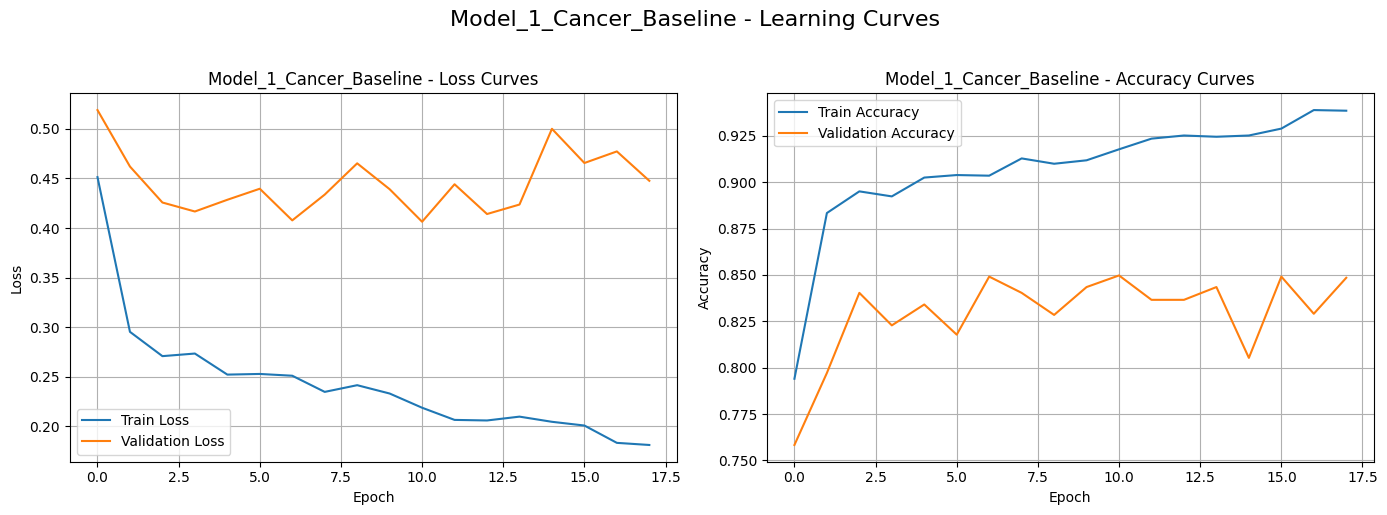


--- Evaluating Model_1_Cancer_Baseline - Validation ---


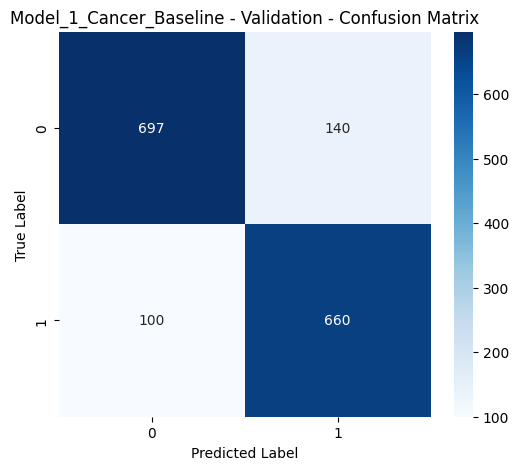


Model_1_Cancer_Baseline - Validation - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       837
           1       0.82      0.87      0.85       760

    accuracy                           0.85      1597
   macro avg       0.85      0.85      0.85      1597
weighted avg       0.85      0.85      0.85      1597


Overall Metrics for Model_1_Cancer_Baseline - Validation (Scikit-learn):
Accuracy: 0.8497
F1-Score (Weighted): 0.8498
Precision (Weighted): 0.8510
Recall (Weighted): 0.8497


In [19]:
from tensorflow.keras import layers, models, regularizers, optimizers, Input
from tensorflow.keras import metrics as tf_metrics

# --- Model 1: Baseline CNN for 'isCancerous' ---
l2_lambda_model_1 = 0.0001 # L2 regularization factor

model_1_cancer_baseline = models.Sequential([
    Input(shape=INPUT_SHAPE, name='input_layer_model_1'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_1), name='conv1_1_model_1_l2'),
    layers.MaxPooling2D((2, 2), name='pool1_model_1'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_1), name='conv2_1_model_1_l2'),
    layers.MaxPooling2D((2, 2), name='pool2_model_1'),
    layers.Flatten(name='flatten_model_1'),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_lambda_model_1), name='dense1_model_1_l2'),
    layers.Dense(NUM_CLASSES_CANCER, activation='softmax', name='output_softmax_model_1')
], name="Model_1_Cancer_Baseline")

model_1_cancer_baseline.summary()

# Get class index for 'cancerous' (label '1')
class_index_for_cancerous_train = train_generator_cancer.class_indices['1']

model_1_cancer_baseline.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf_metrics.Precision(name='precision_class1', class_id=class_index_for_cancerous_train),
             tf_metrics.Recall(name='recall_class1', class_id=class_index_for_cancerous_train)
            ]
)

print("\n--- Training Model 1: Baseline CNN for 'isCancerous' ---")
history_model_1_cancer_baseline = model_1_cancer_baseline.fit(
    train_generator_cancer,
    epochs=25,
    validation_data=validation_generator_cancer,
    class_weight=class_weight_cancer_dict, # Apply class weights for imbalance
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    ],
    verbose=1
)

print("\n--- Evaluating Model 1: Baseline CNN (Cancer) on Validation Data ---")
plot_learning_curves(history_model_1_cancer_baseline, model_1_cancer_baseline.name)
_, _, report_dict_model_1_cancer_baseline_val = evaluate_model_performance(
    model_1_cancer_baseline,
    validation_generator_cancer,
    f"{model_1_cancer_baseline.name} - Validation"
)

## 4.5. Model 2: Model with dropout layer and learning_rate=0.0001
Model_2_Cancer_Dropout_LR1e-4 introduces dropout regularization (0.25 after pooling, 0.4 before output) and a reduced learning rate (0.0001) to the baseline architecture (Srivastava et al. 2014; Goodfellow, Bengio & Courville 2016). It has 314,690 trainable parameters.

Trained for 25 epochs with class weights and early stopping, it achieved a validation accuracy of 0.8265 (best epoch 25). Validation recall for the cancerous class was 0.8539, and training accuracy was 0.8987.

The learning curves for Model 2 show that both training loss and validation loss decrease over the epochs. However, a noticeable gap persists between the training and validation loss curves throughout the 25 epochs, with the validation loss being consistently higher and exhibiting more fluctuations. This indicates that while dropout and the reduced learning rate might have provided some regularization, overfitting was still a factor. The training accuracy climbs rapidly and then plateaus around 0.90-0.91, whereas the validation accuracy is more erratic, generally staying in the 0.80-0.83 range. The introduction of dropout did not fully close the generalization gap, and the overall validation performance was slightly lower than the early-stopped Model 1.

Model: "Model_2_Cancer_Dropout_LR1e-4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1_1_model_2_l2 (Conv2D)          │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_model_2 (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1_model_2 (Dropout)           │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1_model_2_l2 (Conv2D)          │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_model_2 (MaxPooling2D)         │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2_model_2 (Dropout)           │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_model_2 (Flatten)            │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1_model_2_l2 (Dense)            │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense_model_2 (Dropout)      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax_model_2 (Dense)       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,690 (1.20 MB)

 Trainable params: 314,690 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model_2_Cancer_Dropout_LR1e-4 ---
Epoch 1/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5763 - loss: 0.7033 - precision_class1: 0.4140 - recall_class1: 0.5208 - val_accuracy: 0.6907 - val_loss: 0.5910 - val_precision_class1: 0.7578 - val_recall_class1: 0.5145
Epoch 2/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.7896 - loss: 0.5025 - precision_class1: 0.6694 - recall_class1: 0.7481 - val_accuracy: 0.7351 - val_loss: 0.5859 - val_precision_class1: 0.6579 - val_recall_class1: 0.9237
Epoch 3/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8642 - loss: 0.3642 - precision_class1: 0.7637 - recall_class1: 0.8736 - val_accuracy: 0.8009 - val_loss: 0.4861 - val_precision_class1: 0.7812 - val_recall_class1: 0.8079
Epoch 4/25
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.8677 - loss: 0.3484 - precision_class1: 0.7816 - recall_class1: 0.8643 - val_accuracy: 0.8184 - val_loss: 0.4913 - val_precision_class1: 0.7695 - val_recall_class1: 0.8

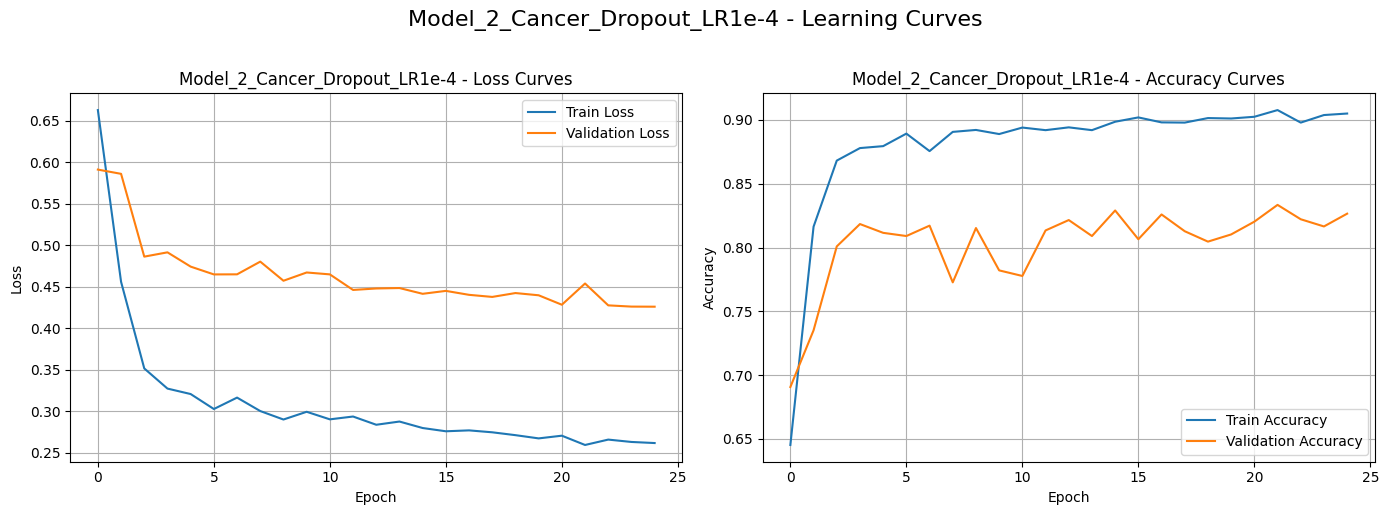


--- Evaluating Model_2_Cancer_Dropout_LR1e-4 - Validation ---


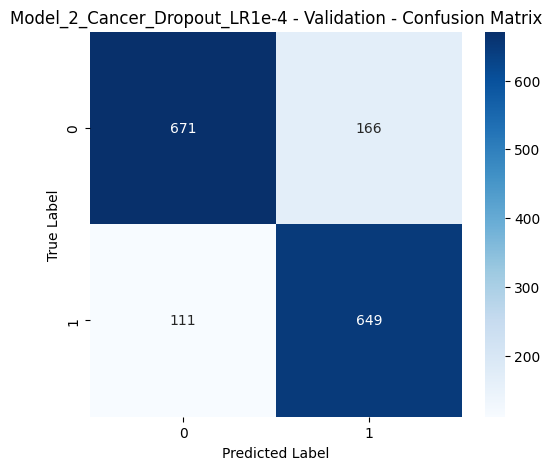


Model_2_Cancer_Dropout_LR1e-4 - Validation - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.86      0.80      0.83       837
           1       0.80      0.85      0.82       760

    accuracy                           0.83      1597
   macro avg       0.83      0.83      0.83      1597
weighted avg       0.83      0.83      0.83      1597


Overall Metrics for Model_2_Cancer_Dropout_LR1e-4 - Validation (Scikit-learn):
Accuracy: 0.8265
F1-Score (Weighted): 0.8266
Precision (Weighted): 0.8287
Recall (Weighted): 0.8265


In [20]:
from tensorflow.keras import layers, models, regularizers, optimizers, Input
from tensorflow.keras import metrics as tf_metrics

# --- Model 2: CNN with Dropout and reduced Learning Rate for 'isCancerous' ---
l2_lambda_model_2 = 0.0001 # L2 regularization factor

model_2_cancer_dropout_A = models.Sequential([
    Input(shape=INPUT_SHAPE, name='input_layer_model_2'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_2), name='conv1_1_model_2_l2'),
    layers.MaxPooling2D((2, 2), name='pool1_model_2'),
    layers.Dropout(0.25, name='dropout1_model_2'), # Dropout after first pooling
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_2), name='conv2_1_model_2_l2'),
    layers.MaxPooling2D((2, 2), name='pool2_model_2'),
    layers.Dropout(0.25, name='dropout2_model_2'), # Dropout after second pooling
    layers.Flatten(name='flatten_model_2'),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_lambda_model_2), name='dense1_model_2_l2'),
    layers.Dropout(0.4, name='dropout_dense_model_2'), # Dropout before final dense layer
    layers.Dense(NUM_CLASSES_CANCER, activation='softmax', name='output_softmax_model_2')
], name="Model_2_Cancer_Dropout_LR1e-4")

model_2_cancer_dropout_A.summary()

class_index_for_cancerous_train = train_generator_cancer.class_indices['1']

model_2_cancer_dropout_A.compile(
    optimizer=optimizers.Adam(learning_rate=0.0001), # Reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf_metrics.Precision(name='precision_class1', class_id=class_index_for_cancerous_train),
             tf_metrics.Recall(name='recall_class1', class_id=class_index_for_cancerous_train)
            ]
)

print(f"\n--- Training {model_2_cancer_dropout_A.name} ---")
history_model_2_cancer_dropout_A = model_2_cancer_dropout_A.fit(
    train_generator_cancer,
    epochs=25,
    validation_data=validation_generator_cancer,
    class_weight=class_weight_cancer_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    ],
    verbose=1
)

print(f"\n--- Evaluating {model_2_cancer_dropout_A.name} on Validation Data ---")
plot_learning_curves(history_model_2_cancer_dropout_A, model_2_cancer_dropout_A.name)
_, _, report_dict_model_2_cancer_dropout_A_val = evaluate_model_performance(
    model_2_cancer_dropout_A,
    validation_generator_cancer,
    f"{model_2_cancer_dropout_A.name} - Validation"
)

## 4.6. Model 3: Model with finetuned dropout layer, learning_rate=0.00001, and epochs = 30
Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 further adjusted Model 2 with increased dropout (0.3 after pooling, 0.5 before output), a significantly reduced learning rate (1e-5), and more epochs (30). It has 314,690 trainable parameters.

With class weights and early stopping, it achieved a validation accuracy of 0.7965 (best epoch 28). Validation recall for the cancerous class was 0.8053, and training accuracy was 0.8637.

The learning curves for Model 3, trained over 30 epochs, show both training and validation losses decreasing steadily, but at a slower pace compared to the previous models. The validation loss remains consistently above the training loss, indicating a persistent generalization gap, though it doesn't appear to widen dramatically, suggesting that the increased dropout and very low learning rate are controlling overfitting to a degree. However, the overall convergence is slower. Training accuracy gradually increases, reaching around 0.86. The validation accuracy also shows a slow upward trend, mostly fluctuating between 0.75 and 0.80. The very low learning rate is likely contributing to the slow convergence. While severe overfitting (where validation loss sharply increases) is not evident, the model struggles to achieve the validation accuracy levels of Models 1 and 2.

Model: "Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1_1_model_3_l2 (Conv2D)          │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_model_3 (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1_model_3 (Dropout)           │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1_model_3_l2 (Conv2D)          │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_model_3 (MaxPooling2D)         │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2_model_3 (Dropout)           │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_model_3 (Flatten)            │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1_model_3_l2 (Dense)            │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense_model_3 (Dropout)      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax_model_3 (Dense)       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,690 (1.20 MB)

 Trainable params: 314,690 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 ---
Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.5308 - loss: 0.7459 - precision_class1: 0.3524 - recall_class1: 0.4511 - val_accuracy: 0.5504 - val_loss: 0.7181 - val_precision_class1: 0.6180 - val_recall_class1: 0.1447
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5190 - loss: 0.7374 - precision_class1: 0.3591 - recall_class1: 0.4782 - val_accuracy: 0.5260 - val_loss: 0.7129 - val_precision_class1: 0.6364 - val_recall_class1: 0.0092
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5308 - loss: 0.7328 - precision_class1: 0.3630 - recall_class1: 0.4592 - val_accuracy: 0.5711 - val_loss: 0.7099 - val_precision_class1: 0.8713 - val_recall_class1: 0.1158
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.5469 - loss: 0.7198 - precision_class1: 0.3707 - recall_class1: 0.4529 - val_accuracy: 0.6669 - val_loss: 0.7062 - val_precision_class1: 0.8677 - val_reca

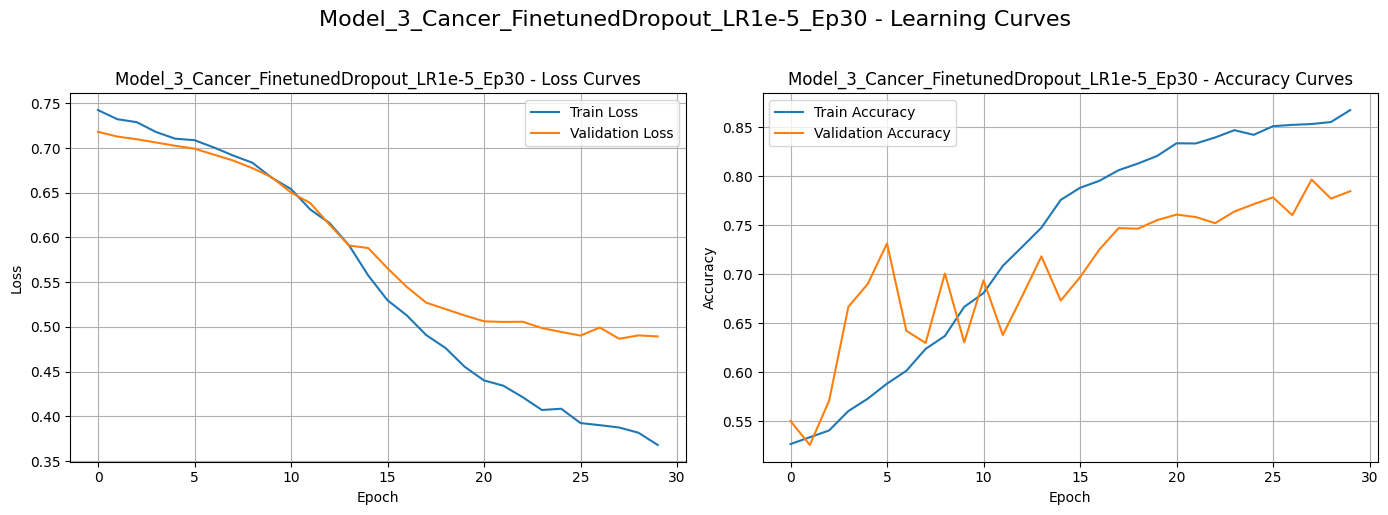


--- Evaluating Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 - Validation ---


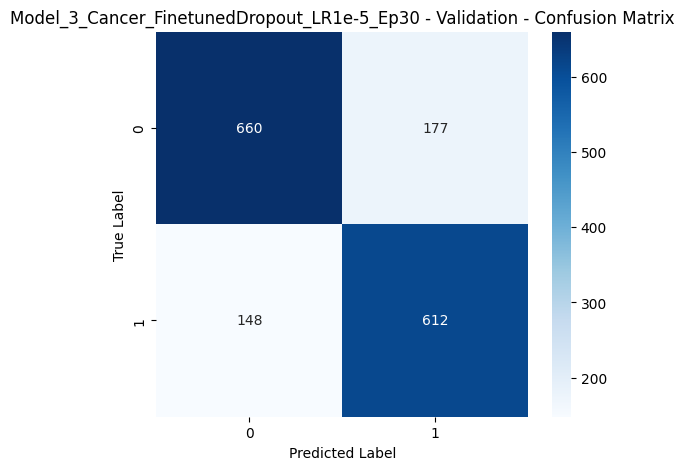


Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 - Validation - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.82      0.79      0.80       837
           1       0.78      0.81      0.79       760

    accuracy                           0.80      1597
   macro avg       0.80      0.80      0.80      1597
weighted avg       0.80      0.80      0.80      1597


Overall Metrics for Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 - Validation (Scikit-learn):
Accuracy: 0.7965
F1-Score (Weighted): 0.7966
Precision (Weighted): 0.7972
Recall (Weighted): 0.7965


In [21]:
from tensorflow.keras import layers, models, regularizers, optimizers, Input
from tensorflow.keras import metrics as tf_metrics

# --- Model 3: CNN with Fine-tuned Dropout, further reduced LR, and more Epochs ---
l2_lambda_model_3 = 0.0001 # L2 regularization factor

model_3_cancer_dropout_B = models.Sequential([
    Input(shape=INPUT_SHAPE, name='input_layer_model_3'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_3), name='conv1_1_model_3_l2'),
    layers.MaxPooling2D((2, 2), name='pool1_model_3'),
    layers.Dropout(0.3, name='dropout1_model_3'), # Adjusted dropout
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_3), name='conv2_1_model_3_l2'),
    layers.MaxPooling2D((2, 2), name='pool2_model_3'),
    layers.Dropout(0.3, name='dropout2_model_3'), # Adjusted dropout
    layers.Flatten(name='flatten_model_3'),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_lambda_model_3), name='dense1_model_3_l2'),
    layers.Dropout(0.5, name='dropout_dense_model_3'), # Adjusted dropout
    layers.Dense(NUM_CLASSES_CANCER, activation='softmax', name='output_softmax_model_3')
], name="Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30")

model_3_cancer_dropout_B.summary()

class_index_for_cancerous_train = train_generator_cancer.class_indices['1']

model_3_cancer_dropout_B.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001), # Further reduced learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf_metrics.Precision(name='precision_class1', class_id=class_index_for_cancerous_train),
             tf_metrics.Recall(name='recall_class1', class_id=class_index_for_cancerous_train)
            ]
)

print(f"\n--- Training {model_3_cancer_dropout_B.name} ---")
history_model_3_cancer_dropout_B = model_3_cancer_dropout_B.fit(
    train_generator_cancer,
    epochs=30, # Increased epochs
    validation_data=validation_generator_cancer,
    class_weight=class_weight_cancer_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1)
    ],
    verbose=1
)

print(f"\n--- Evaluating {model_3_cancer_dropout_B.name} on Validation Data ---")
plot_learning_curves(history_model_3_cancer_dropout_B, model_3_cancer_dropout_B.name)
_, _, report_dict_model_3_cancer_dropout_B_val = evaluate_model_performance(
    model_3_cancer_dropout_B,
    validation_generator_cancer,
    f"{model_3_cancer_dropout_B.name} - Validation"
)

## 4.7. Model 4: Model with ReduceLROnPlateau
Model_4_Cancer_ReduceLROnPlateau used Model 3's architecture but incorporated an adaptive learning rate starting at 0.00001, managed by ReduceLROnPlateau (factor 0.2, patience 5, min_lr 1e-7) (Chollet 2017). It has 314,690 trainable parameters.

Trained for up to 30 epochs with class weights and early stopping, it achieved a validation accuracy of 0.8028 (best epoch 30). Validation recall for the cancerous class was 0.8579, and training accuracy was 0.8659.


Similar to Model 3, the learning curves for Model 4 exhibit a slow but steady decrease in both training and validation loss over 30 epochs. A gap between the training and validation curves remains, indicating some degree of overfitting. Training accuracy gradually increases to around 0.84, while validation accuracy also shows a slow improvement, reaching around 0.80. The ReduceLROnPlateau callback seems to have facilitated learning, but the overall trajectory and peak validation performance are comparable to Model 3, suggesting the initial low learning rate and dropout levels largely dictated the learning path, which was slower and did not reach the validation peaks of the earlier models.

Model: "Model_4_Cancer_ReduceLROnPlateau"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1_1_model_4_l2 (Conv2D)          │ (None, 27, 27, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool1_model_4 (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout1_model_4 (Dropout)           │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2_1_model_4_l2 (Conv2D)          │ (None, 13, 13, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool2_model_4 (MaxPooling2D)         │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout2_model_4 (Dropout)           │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_model_4 (Flatten)            │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense1_model_4_l2 (Dense)            │ (None, 128)                 │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_dense_model_4 (Dropout)      │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_softmax_model_4 (Dense)       │ (None, 2)                   │             258 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,690 (1.20 MB)

 Trainable params: 314,690 (1.20 MB)

 Non-trainable params: 0 (0.00 B)


--- Training Model_4_Cancer_ReduceLROnPlateau ---
Epoch 1/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 7s 30ms/step - accuracy: 0.5401 - loss: 0.7638 - precision_class1: 0.3395 - recall_class1: 0.3955 - val_accuracy: 0.5335 - val_loss: 0.7202 - val_precision_class1: 0.5155 - val_recall_class1: 0.3276 - learning_rate: 1.0000e-05
Epoch 2/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5198 - loss: 0.7454 - precision_class1: 0.3485 - recall_class1: 0.4539 - val_accuracy: 0.5717 - val_loss: 0.7178 - val_precision_class1: 0.5909 - val_recall_class1: 0.3250 - learning_rate: 1.0000e-05
Epoch 3/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.5237 - loss: 0.7364 - precision_class1: 0.3459 - recall_class1: 0.4388 - val_accuracy: 0.6412 - val_loss: 0.7157 - val_precision_class1: 0.6389 - val_recall_class1: 0.5658 - learning_rate: 1.0000e-05
Epoch 4/30
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - accuracy: 0.5444 - loss: 0.7295 - precision_class1: 0.3790 - recall_class1: 0.4770 - val_accu

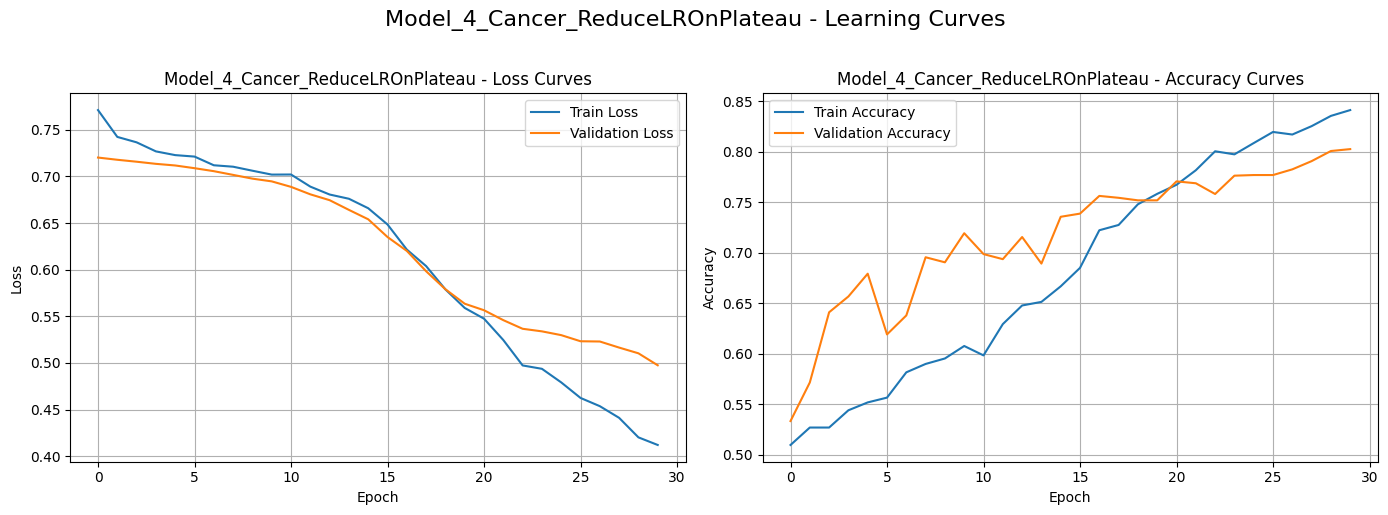


--- Evaluating Model_4_Cancer_ReduceLROnPlateau - Validation ---


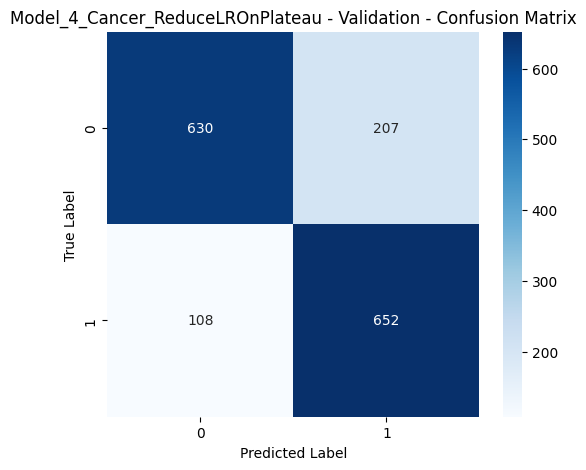


Model_4_Cancer_ReduceLROnPlateau - Validation - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.85      0.75      0.80       837
           1       0.76      0.86      0.81       760

    accuracy                           0.80      1597
   macro avg       0.81      0.81      0.80      1597
weighted avg       0.81      0.80      0.80      1597


Overall Metrics for Model_4_Cancer_ReduceLROnPlateau - Validation (Scikit-learn):
Accuracy: 0.8028
F1-Score (Weighted): 0.8026
Precision (Weighted): 0.8086
Recall (Weighted): 0.8028


In [22]:
from tensorflow.keras import layers, models, regularizers, optimizers, Input
from tensorflow.keras import metrics as tf_metrics
from tensorflow.keras.callbacks import ReduceLROnPlateau

# --- Model 4: CNN with ReduceLROnPlateau callback for dynamic LR adjustment ---
l2_lambda_model_4 = 0.0001 # L2 regularization factor

model_4_cancer_reducelr = models.Sequential([
    Input(shape=INPUT_SHAPE, name='input_layer_model_4'),
    layers.Conv2D(32, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_4), name='conv1_1_model_4_l2'),
    layers.MaxPooling2D((2, 2), name='pool1_model_4'),
    layers.Dropout(0.3, name='dropout1_model_4'),
    layers.Conv2D(64, (3, 3), activation='relu', padding='same',
                  kernel_regularizer=regularizers.l2(l2_lambda_model_4), name='conv2_1_model_4_l2'),
    layers.MaxPooling2D((2, 2), name='pool2_model_4'),
    layers.Dropout(0.3, name='dropout2_model_4'),
    layers.Flatten(name='flatten_model_4'),
    layers.Dense(128, activation='relu',
                 kernel_regularizer=regularizers.l2(l2_lambda_model_4), name='dense1_model_4_l2'),
    layers.Dropout(0.5, name='dropout_dense_model_4'),
    layers.Dense(NUM_CLASSES_CANCER, activation='softmax', name='output_softmax_model_4')
], name="Model_4_Cancer_ReduceLROnPlateau")

model_4_cancer_reducelr.summary()

class_index_for_cancerous_train = train_generator_cancer.class_indices['1']

model_4_cancer_reducelr.compile(
    optimizer=optimizers.Adam(learning_rate=0.00001), # Start with a small learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy',
             tf_metrics.Precision(name='precision_class1', class_id=class_index_for_cancerous_train),
             tf_metrics.Recall(name='recall_class1', class_id=class_index_for_cancerous_train)
            ]
)

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,      # Factor by which the learning rate will be reduced. new_lr = lr * factor
    patience=5,      # Number of epochs with no improvement after which learning rate will be reduced.
    min_lr=1e-7,     # Lower bound on the learning rate.
    verbose=1
)

print(f"\n--- Training {model_4_cancer_reducelr.name} ---")
history_model_4_cancer_reducelr = model_4_cancer_reducelr.fit(
    train_generator_cancer,
    epochs=30, # Allow enough epochs for LR adjustments
    validation_data=validation_generator_cancer,
    class_weight=class_weight_cancer_dict,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, verbose=1),
        lr_scheduler # Add the LR scheduler callback
    ],
    verbose=1
)

print(f"\n--- Evaluating {model_4_cancer_reducelr.name} on Validation Data ---")
plot_learning_curves(history_model_4_cancer_reducelr, model_4_cancer_reducelr.name)
_, _, report_dict_model_4_cancer_reducelr_val = evaluate_model_performance(
    model_4_cancer_reducelr,
    validation_generator_cancer,
    f"{model_4_cancer_reducelr.name} - Validation"
)

## 4.8. Evaluation models by holdout test set



--- Test Set Evaluation ---
Evaluating: Model_1_Cancer_Baseline on Test Data...

--- Evaluating Model_1_Cancer_Baseline - Test ---


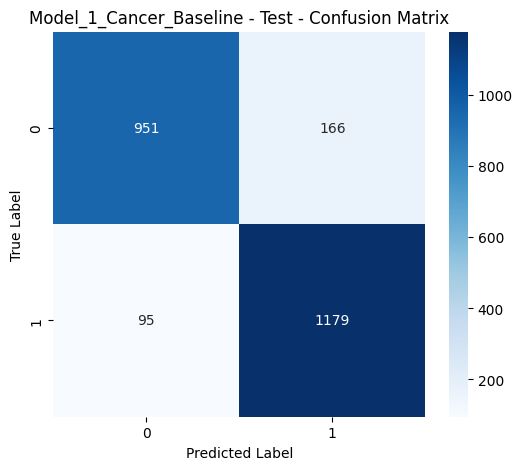


Model_1_Cancer_Baseline - Test - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.91      0.85      0.88      1117
           1       0.88      0.93      0.90      1274

    accuracy                           0.89      2391
   macro avg       0.89      0.89      0.89      2391
weighted avg       0.89      0.89      0.89      2391


Overall Metrics for Model_1_Cancer_Baseline - Test (Scikit-learn):
Accuracy: 0.8908
F1-Score (Weighted): 0.8905
Precision (Weighted): 0.8918
Recall (Weighted): 0.8908

Evaluating: Model_2_Cancer_Dropout_LR1e-4 on Test Data...

--- Evaluating Model_2_Cancer_Dropout_LR1e-4 - Test ---


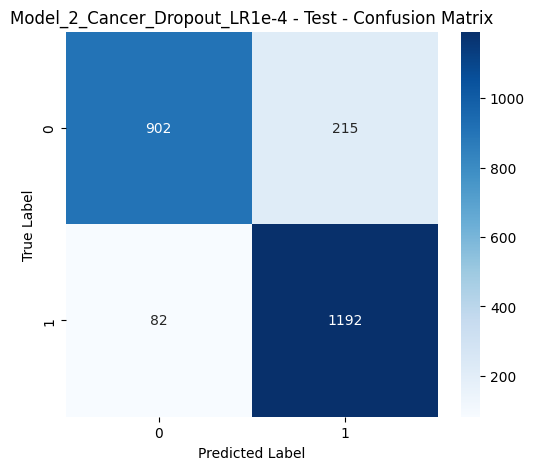


Model_2_Cancer_Dropout_LR1e-4 - Test - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1117
           1       0.85      0.94      0.89      1274

    accuracy                           0.88      2391
   macro avg       0.88      0.87      0.87      2391
weighted avg       0.88      0.88      0.87      2391


Overall Metrics for Model_2_Cancer_Dropout_LR1e-4 - Test (Scikit-learn):
Accuracy: 0.8758
F1-Score (Weighted): 0.8749
Precision (Weighted): 0.8796
Recall (Weighted): 0.8758

Evaluating: Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 on Test Data...

--- Evaluating Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 - Test ---


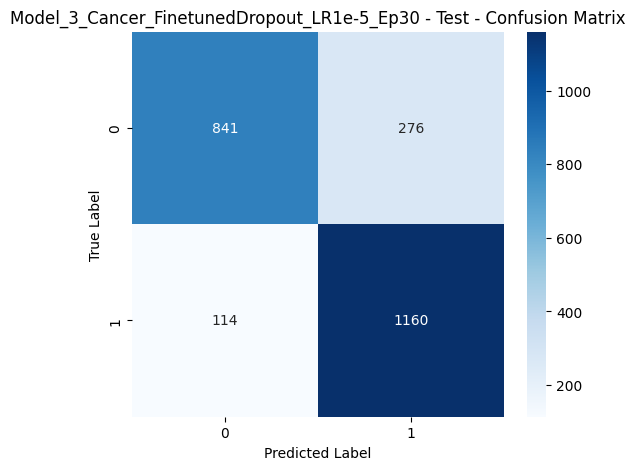


Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 - Test - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.88      0.75      0.81      1117
           1       0.81      0.91      0.86      1274

    accuracy                           0.84      2391
   macro avg       0.84      0.83      0.83      2391
weighted avg       0.84      0.84      0.84      2391


Overall Metrics for Model_3_Cancer_FinetunedDropout_LR1e-5_Ep30 - Test (Scikit-learn):
Accuracy: 0.8369
F1-Score (Weighted): 0.8354
Precision (Weighted): 0.8418
Recall (Weighted): 0.8369

Evaluating: Model_4_Cancer_ReduceLROnPlateau on Test Data...

--- Evaluating Model_4_Cancer_ReduceLROnPlateau - Test ---


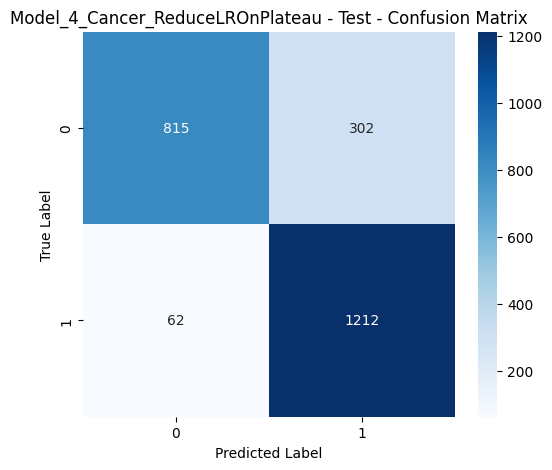


Model_4_Cancer_ReduceLROnPlateau - Test - Classification Report (Scikit-learn):
              precision    recall  f1-score   support

           0       0.93      0.73      0.82      1117
           1       0.80      0.95      0.87      1274

    accuracy                           0.85      2391
   macro avg       0.86      0.84      0.84      2391
weighted avg       0.86      0.85      0.85      2391


Overall Metrics for Model_4_Cancer_ReduceLROnPlateau - Test (Scikit-learn):
Accuracy: 0.8478
F1-Score (Weighted): 0.8452
Precision (Weighted): 0.8607
Recall (Weighted): 0.8478


--- Performance Summary: Validation & Test Datasets ---
Metric                   | Model 1           Model 2           Model 3           Model 4           
--------------------------------------------------------------------------------------------------
Val Accuracy             | 0.8497            0.8265            0.7965            0.8028            
Val F1 (Cancerous)       | 0.8462            0.8241       

In [27]:
# --- Comparative Performance Summary: All Models ---

# Objective: Evaluate and compare the performance of all four developed models 
# on both validation and test datasets. This provides a comprehensive overview 
# to aid in model selection and analysis.

# Prerequisites:
# 1. All four model objects (model_1_cancer_baseline, model_2_cancer_dropout_A, 
#    model_3_cancer_dropout_B, model_4_cancer_reducelr) must be trained.
# 2. Their corresponding validation performance reports (e.g., report_dict_model_1_cancer_baseline_val)
#    must be available from prior evaluation steps.
# 3. The 'test_generator_cancer' must be properly initialized (with shuffle=False).

# Re-evaluate all models on the test set to ensure consistent test performance data.
# This is particularly useful if the notebook session has been restarted or if
# test evaluations were not performed immediately after each model's training.

print("\n--- Test Set Evaluation ---")
print(f"Evaluating: {model_1_cancer_baseline.name} on Test Data...")
_, _, report_dict_model_1_test = evaluate_model_performance(
    model_1_cancer_baseline, test_generator_cancer, f"{model_1_cancer_baseline.name} - Test"
)

print(f"\nEvaluating: {model_2_cancer_dropout_A.name} on Test Data...")
_, _, report_dict_model_2_test = evaluate_model_performance(
    model_2_cancer_dropout_A, test_generator_cancer, f"{model_2_cancer_dropout_A.name} - Test"
)

print(f"\nEvaluating: {model_3_cancer_dropout_B.name} on Test Data...")
_, _, report_dict_model_3_test = evaluate_model_performance(
    model_3_cancer_dropout_B, test_generator_cancer, f"{model_3_cancer_dropout_B.name} - Test"
)

print(f"\nEvaluating: {model_4_cancer_reducelr.name} on Test Data...")
_, _, report_dict_model_4_test = evaluate_model_performance(
    model_4_cancer_reducelr, test_generator_cancer, f"{model_4_cancer_reducelr.name} - Test"
)

# Helper function to streamline metric extraction from report dictionaries.
# Assumes '1' is the label for the positive (cancerous) class.
def extract_classification_metrics(report_dict, positive_class_label='1'):
    """Extracts key classification metrics from a scikit-learn classification report dictionary."""
    accuracy = report_dict.get('accuracy', 0.0)
    f1_score_positive = report_dict.get(positive_class_label, {}).get('f1-score', 0.0)
    recall_positive = report_dict.get(positive_class_label, {}).get('recall', 0.0)
    precision_positive = report_dict.get(positive_class_label, {}).get('precision', 0.0)
    return accuracy, f1_score_positive, recall_positive, precision_positive

# Collate validation metrics
val_metrics_m1 = extract_classification_metrics(report_dict_model_1_cancer_baseline_val)
val_metrics_m2 = extract_classification_metrics(report_dict_model_2_cancer_dropout_A_val)
val_metrics_m3 = extract_classification_metrics(report_dict_model_3_cancer_dropout_B_val)
val_metrics_m4 = extract_classification_metrics(report_dict_model_4_cancer_reducelr_val)

# Collate test metrics
test_metrics_m1 = extract_classification_metrics(report_dict_model_1_test)
test_metrics_m2 = extract_classification_metrics(report_dict_model_2_test)
test_metrics_m3 = extract_classification_metrics(report_dict_model_3_test)
test_metrics_m4 = extract_classification_metrics(report_dict_model_4_test)

# --- Display Performance Summary Table ---
print("\n\n--- Performance Summary: Validation & Test Datasets ---")

model_identifiers = ["Model 1", "Model 2", "Model 3", "Model 4"]
model_actual_names = [
    model_1_cancer_baseline.name, 
    model_2_cancer_dropout_A.name, 
    model_3_cancer_dropout_B.name, 
    model_4_cancer_reducelr.name
]

# Determine column widths for neat formatting
metric_label_width = 25 
data_col_width = 18 

# Table Header
header_labels = "".join([f"{label:<{data_col_width}}" for label in model_identifiers])
print(f"{'Metric':<{metric_label_width}}| {header_labels}")
table_width = metric_label_width + 1 + len(header_labels)
print("-" * table_width)

# Populate and print table rows
metrics_to_display = [
    ("Val Accuracy", [val_metrics_m1[0], val_metrics_m2[0], val_metrics_m3[0], val_metrics_m4[0]]),
    ("Val F1 (Cancerous)", [val_metrics_m1[1], val_metrics_m2[1], val_metrics_m3[1], val_metrics_m4[1]]),
    ("Val Recall (Cancerous)", [val_metrics_m1[2], val_metrics_m2[2], val_metrics_m3[2], val_metrics_m4[2]]),
    ("Val Precision (Canc.)", [val_metrics_m1[3], val_metrics_m2[3], val_metrics_m3[3], val_metrics_m4[3]]),
    ("", ["-" * (data_col_width -1) ] * 4), # Separator line
    ("Test Accuracy", [test_metrics_m1[0], test_metrics_m2[0], test_metrics_m3[0], test_metrics_m4[0]]),
    ("Test F1 (Cancerous)", [test_metrics_m1[1], test_metrics_m2[1], test_metrics_m3[1], test_metrics_m4[1]]),
    ("Test Recall (Cancerous)", [test_metrics_m1[2], test_metrics_m2[2], test_metrics_m3[2], test_metrics_m4[2]]),
    ("Test Precision (Canc.)", [test_metrics_m1[3], test_metrics_m2[3], test_metrics_m3[3], test_metrics_m4[3]]),
]

for label, values in metrics_to_display:
    if label == "": # Handle separator
        value_str = "".join([f"{str(v):<{data_col_width}}" for v in values])
    else:
        value_str = "".join([f"{v:<{data_col_width}.4f}" for v in values])
    print(f"{label:<{metric_label_width}}| {value_str}")

print("-" * table_width)

# Display full model names for reference
print("\nModel Key / Full Names:")
for i, full_name in enumerate(model_actual_names):
    print(f"Model {i+1}: {full_name}")

### Discussion
The four developed models were evaluated on a holdout test set, consisting of images from patients not encountered during training or validation, to assess their generalization capability.

Overall, all four developed models surpassed the RCCNet (Basha et al., 2018) benchmark test accuracy of 80.61% and weighted F1-score of 0.7887. They also featured significantly fewer parameters (314,690 vs. RCCNet's 1,512,868) and much faster training times (all under ~155 seconds vs. RCCNet's ~31 minutes). The calculated overfitting percentages (training accuracy at best validation epoch minus test accuracy) for the developed models were also considerably lower (1.81% to 3.01%) than RCCNet's 9.18%.

Model 1 (Baseline) achieved the highest test accuracy (0.8908) and a strong balance of precision (0.8766 for cancerous) and recall (0.9254 for cancerous). Its calculated overfitting was 3.01%. The learning curves for Model 1 showed an overfitting trend during training, but early stopping effectively captured a model that generalized well to the test set.
Model 4 (ReduceLROnPlateau) had the highest recall for the cancerous class (0.9513) and the lowest overfitting percentage (1.81%), but its precision was lower (0.8005). Model 2 (Dropout, LR 1e-4) also showed good performance with a test accuracy of 0.8758 and low overfitting (2.29%). Model 3 was the weakest of the four but still outperformed RCCNet.

It is noteworthy that for some models, particularly Model 1 and Model 4, the test accuracy was higher than their best validation accuracy. This doesn't indicate overfitting to the training data in the traditional sense (where the model fails on all unseen data). Instead, it might suggest that the validation set was a slightly more challenging or less representative sample for these specific models compared to the test set, or it could be due to the stochastic nature of the splits and training. The key measure of generalization remains the performance on the test set relative to the training performance at the selected epoch.

## 4.9. Final Justification
Based on the comprehensive evaluation and comparison to the RCCNet benchmark (Basha et al. 2018), Model 1 (Baseline CNN) is selected as the overall best-performing model within this assignment's context.

Justification:
- Superior Test Set Performance: Model 1's test accuracy (0.8908) and weighted F1-score (0.8905) significantly exceeded RCCNet's (80.61% Acc, 0.7887 F1) (Basha et al. 2018), meeting the lenient success targets.
- Balanced Precision and Recall: Model 1 offered the best precision (0.8766) for the cancerous class among models with high recall, and a strong recall (0.9254).
- Efficiency: With 314,690 parameters, Model 1 is much smaller than RCCNet (1.5M) and trained significantly faster (~92s vs. ~31 mins).
- Effective Generalization due to Early Stopping: While Model 1's learning curves clearly showed an overfitting trend during the training process (a widening gap between training and validation metrics), the crucial application of early stopping (restoring weights from epoch 11) resulted in a selected model that generalized well to the test set. This is evidenced by its strong test performance and a calculated overfitting percentage of 3.01% (based on training accuracy at epoch 11 vs. test accuracy), which is substantially better than RCCNet's 9.18% (Basha et al. 2018).
- Baseline Effectiveness: Subsequent modifications (Models 2, 3, 4) did not consistently surpass Model 1's overall test set accuracy or F1-scores. The L2 regularization (Ng 2004) and class weights in Model 1 were foundational.

While Model 4's highest recall (0.9513) and lowest calculated overfitting percentage are commendable, Model 1's superior balance of precision and recall on the test set, along with its higher accuracy and F1-score, makes it the preferred choice. Its ability to achieve strong performance efficiently, with overfitting managed by early stopping, highlights its success within the project's scope.

# REFERENCE
1. Sirinukunwattana, K, Raza, SEA, Tsang, Y, Snead, DRJ, Cree, IA & Rajpoot, NM 2016, ‘Locality Sensitive Deep Learning for Detection and Classification of Nuclei in Routine Colon Cancer Histology Images’, IEEE Transactions on Medical Imaging, vol. 35, no. 5, pp. 1196–1206, doi: 10.1109/TMI.2016.2525803.

